
# Exercise XX: Gibbs sampling

In this notebook we show how to use CUQIpy to perform Gibbs sampling.
Gibbs sampling is a Markov chain Monte Carlo (MCMC) method for
sampling a joint probability distribution of multiple random variables.

Compared to sampling all variables simultaneously, Gibbs sampling samples the variables of the distribution sequentially, one variable at a time. 

The sampling of each variable is done by sampling from the conditional
distribution of that variable given (fixed, previously sampled) values
of the other variables.

This is often a very efficient way of sampling from a joint
distribution if the conditional distributions are easy to sample
from. This is one way to exploit the structure of the joint
distribution. On the other hand, if the conditional distributions
are highly correlated and/or are difficult to sample from, then
Gibbs sampling can be very inefficient.

For these reasons, Gibbs sampling is often a double-edged sword,
that needs to be used in the right context.


## Learning objectives

Going through this notebook, you will learn how to:

- Define a hierarchical Bayesian model using CUQIpy.
- Perform Gibbs sampling on each variable of the model.
- Visualize the results of the sampling.

## Table of contents



## Setup
We start by importing the necessary modules



In [1]:
import sys; sys.path.append('../../cuqipy/')
import numpy as np
import matplotlib.pyplot as plt
from cuqi.testproblem import Deconvolution1D
from cuqi.distribution import GaussianCov, Gamma, JointDistribution, GMRF, Laplace_diff
from cuqi.sampler import Gibbs, Linear_RTO, Conjugate, UnadjustedLaplaceApproximation, ConjugateApprox

## Deterministic forward model and data
Consider an inverse problem
$$y=Ax,$$
where $A: \mathbb{R}^n \to \mathbb{R}^m$ is the forward model of the inverse problem, $y\in\mathbb{R}^m$ is the data and $x\in \mathbb{R}^n$ is the parameter of interest.

In this case, we assume that the forward model is a convolution operator. We load this example from the testproblem library of CUQIpy and visualize the
true solution (sharp signal) and data (convolved signal).

c:\Users\Nicolai\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Text(0.5, 1.0, 'Observed data')

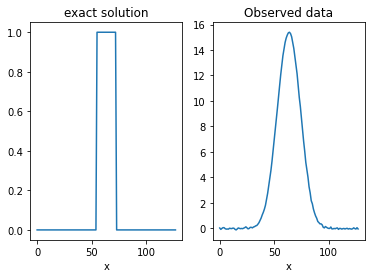

In [4]:
# Model and data
A, y_obs, probinfo = Deconvolution1D.get_components(phantom='square')

# Get dimension of signal
n = A.domain_dim

# Plot exact solution and observed data
plt.subplot(121)
probinfo.exactSolution.plot()
plt.title('exact solution')

plt.subplot(122)
y_obs.plot()
plt.title("Observed data")

## Hierarchical Bayesian model

We are now going to define a hierarchical Bayesian model for the inverse problem.


Because the observed data is corrupted by Gaussian noise, we can assume a Gaussian distribution for $y$. Furthermore, we model the prior distribution of the parameter of interest $x$ as a Gaussian Markov random field [(GMRF)](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.distribution/cuqi.distribution.GMRF.html#cuqi.distribution.GMRF).

Assuming we do not know the noise level or the precision of the prior distribution, we add both as hyperparameters to the model. We assume weakly informative priors for both hyperparameters.

The model can be written as

\begin{align*}
        d &\sim \mathrm{Gamma}(1, 10^{-4}) \\
        l &\sim \mathrm{Gamma}(1, 10^{-4}) \\
        \mathbf{x} &\sim \mathrm{GMRF}(\mathbf{0}, d) \\
        \mathbf{y} &\sim \mathcal{N}(\mathbf{A} \mathbf{x}, l^{-1} \mathbf{I}_m)
\end{align*}

In CUQIpy the model can be defined as follows:



In [5]:
# Define distributions
d = Gamma(1, 1e-4)
l = Gamma(1, 1e-4)
x = GMRF(np.zeros(n), lambda d: d)
y = GaussianCov(A@x, lambda l: 1/l)

# Combine into a joint distribution
joint = JointDistribution(d, l, x, y)

# View the joint distribution
print(joint)

JointDistribution(
    Equation: 
	p(d,l,x,y) = p(d)p(l)p(x|d)p(y|x,l)
    Densities: 
	d ~ CUQI Gamma.
	l ~ CUQI Gamma.
	x ~ CUQI GMRF. Conditioning variables ['d'].
	y ~ CUQI GaussianCov. Conditioning variables ['x', 'l'].
)


Notice that the joint distribution prints a mathematical expression
for the density functions that make up $p(d,l,\mathbf{x},\mathbf{y})$.
In this case they are all distributions, but this need not be the case.



## Defining the posterior distribution

Now we define the posterior distribution, which is the joint distribution
conditioned on the observed data. That is, $p(d, l, \mathbf{x} \mid \mathbf{y}=\mathbf{y}_\mathrm{obs})$

This is done in the following way:



In [ ]:
# Define posterior by conditioning on the data
posterior = joint(y=y_obs)

# View the structure of the posterior
print(posterior)

Notice that after conditioning on the data, the distribution associated with
$\mathbf{y}$ became a likelihood function and that the posterior is now
a joint distribution of the variables $d$, $l$, $\mathbf{x}$.



## Gibbs Sampler


The hierarchical model above has some important properties that we
can exploit to make the sampling more efficient. First, note that
the Gamma distribution are conjugate priors for the precision of
the Gaussian distributions. This means that we can efficiently sample
from $d$ and $l$ conditional on the other variables.

Second, note that the prior distribution of $\mathbf{x}$ is
a Gaussian Markov random field (GMRF) and that the distribution for
$\mathbf{y}$ is also Gaussian with a Linear operator acting
on $\mathbf{x}$ as the mean variable. This means that we can
efficiently sample from $\mathbf{x}$ conditional on the other
variables using the ``Linear_RTO`` sampler.

Taking these two facts into account, we can define a Gibbs sampler
that uses the ``Conjugate`` sampler for $d$ and $l$ and
the ``Linear_RTO`` sampler for $\mathbf{x}$.

This is done in CUQIpy as follows:



In [ ]:
# Define sampling strategy
sampling_strategy = {
    'x': Linear_RTO,
    'd': Conjugate,
    'l': Conjugate
}

# Define Gibbs sampler
sampler = Gibbs(posterior, sampling_strategy)

# Run sampler
samples = sampler.sample(Ns=1000, Nb=200)

## Analyze results

After sampling we can inspect the results. The samples are stored
as a dictionary with the variable names as keys. Samples for each 
variable is stored as a CUQIpy Samples object which contains the
many convenience methods for diagnostics and plotting of MCMC samples.



In [ ]:
# Plot credible intervals for the signal
samples['x'].plot_ci(exact=probinfo.exactSolution)

Trace plot for d



In [ ]:
samples['d'].plot_trace(figsize=(8,2))

Trace plot for l



In [ ]:
samples['l'].plot_trace(figsize=(8,2))

## Switching to a piecewise constant prior

Notice that while the sampling went well in the previous example,
the posterior distribution did not match the characteristics of
the exact solution. We can improve this result by switching to a
prior that better matches the exact solution $\mathbf{x}$.

One choice is the Laplace difference prior, which assumes a
Laplace distribution for the differences between neighboring
elements of $\mathbf{x}$. That is,

\begin{align}\mathbf{x} \sim \text{Laplace_diff}(\mathbf{0}, d^{-1}),\end{align}

which means that $x_i-x_{i-1} \sim \mathrm{Laplace}(0, d^{-1})$.

This prior is implemented in CUQIpy as the ``Laplace_diff`` distribution.
To update our model we simply need to replace the ``GMRF`` distribution
with the ``Laplace_diff`` distribution. Note that the Laplace distribution
is defined via a scale parameter, so we invert the parameter $d$.

This laplace distribution and new posterior can be defined as follows:



In [ ]:
# Define new distribution for x
x = Laplace_diff(np.zeros(n), lambda d: 1/d)

# Define new joint distribution with piecewise constant prior
joint_Ld = JointDistribution(d, l, x, y)

# Define new posterior by conditioning on the data
posterior_Ld = joint_Ld(y=y_obs)

print(posterior_Ld)

## Gibbs Sampler (with Laplace prior)

Using the same approach as ealier we can define a Gibbs sampler
for this new hierarchical model. The only difference is that we
now need to use a different sampler for $\mathbf{x}$ because
the ``Linear_RTO`` sampler only works for Gaussian distributions.

In this case we use the UnadjustedLaplaceApproximation sampler
for $\mathbf{x}$. We also use an approximate Conjugate
sampler for $d$ which approximately samples from the
posterior distribution of $d$ conditional on the other
variables in an efficient manner. For more details see e.g.
`this paper <https://arxiv.org/abs/2104.06919>`.



In [ ]:
# Define sampling strategy
sampling_strategy = {
    'x': UnadjustedLaplaceApproximation,
    'd': ConjugateApprox,
    'l': Conjugate
}

# Define Gibbs sampler
sampler_Ld = Gibbs(posterior_Ld, sampling_strategy)

# Run sampler
samples_Ld = sampler_Ld.sample(Ns=1000, Nb=200)

## Analyze results

Again we can inspect the results.
Here we notice the posterior distribution matches the exact solution much better.



In [ ]:
# Plot credible intervals for the signal
samples_Ld['x'].plot_ci(exact=probinfo.exactSolution)

In [ ]:
samples_Ld['d'].plot_trace(figsize=(8,2))

In [ ]:
samples_Ld['l'].plot_trace(figsize=(8,2))